In [5]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read in our dataset from the csv file
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [12]:
# Check out the column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric8  124494 non-null  int64 
 10  metric9  124494 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 10.4+ MB


# Check for null values

We may need to fill in some null values.

In [13]:
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric8    0
metric9    0
dtype: int64

What is the device column? How many devices are there?

In [20]:
len(df.device.unique())

1169

In [21]:
df.device.value_counts()

Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: device, Length: 1169, dtype: int64

It appears there are 1169 unique devices. What is the distribution here?

<AxesSubplot:xlabel='device', ylabel='count'>

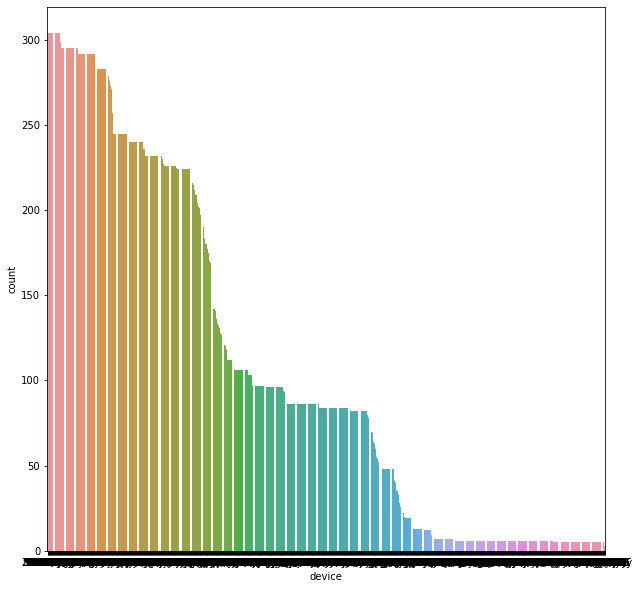

In [28]:
plt.figure(figsize=(10,10))
sns.countplot(x='device', data=df, order=df.device.value_counts().index)

Lets look at the class distribution.

<AxesSubplot:xlabel='failure', ylabel='count'>

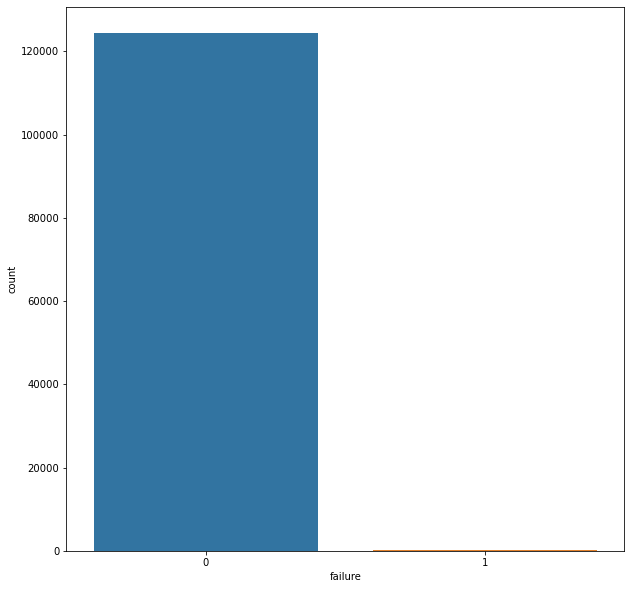

In [29]:
plt.figure(figsize=(10,10))
sns.countplot(x='failure', data=df, order=df.failure.value_counts().index)

<AxesSubplot:>

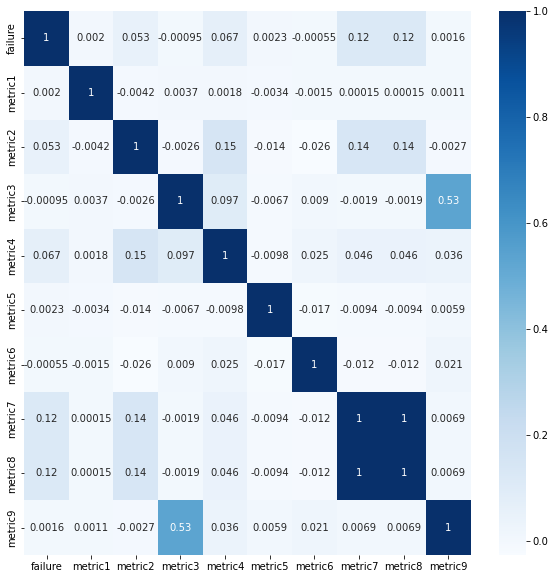

In [7]:
# Perform initial analysis on feature correlation
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

Clearly, metric7 and metric8 are duplicates of each other. We can verify they are the same column with a simple test below.

In [9]:
all(df.metric7 == df.metric8)

True

Clearly, metric7 and metric8 are duplicates, meaning we only have 8 unique features to play with instead of 9. Lets drop metric8.

In [11]:
df.drop(columns='metric7', inplace=True)

It also looks like metric3 and metric9 are somewhat correlated compared to the other features. Lets check that out.

<AxesSubplot:xlabel='metric3', ylabel='metric9'>

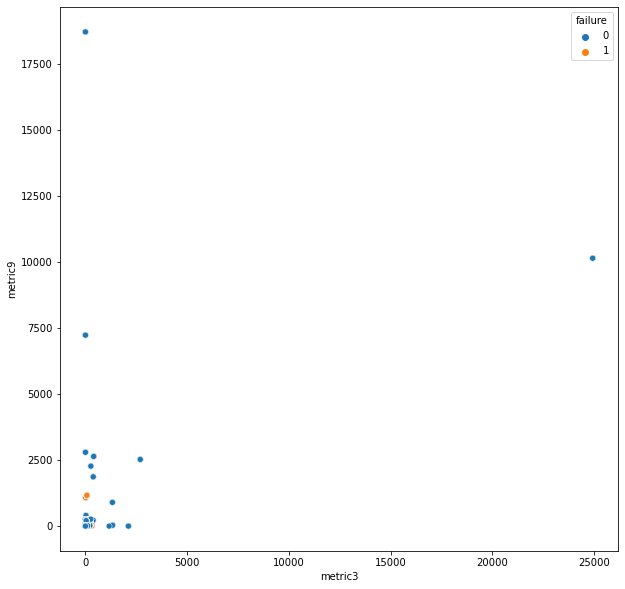

In [31]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='metric3', y='metric9', data=df, hue='failure')

In [47]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV


X = df.loc[:, [x for x in df.columns if x not in ['device', 'failure', 'date']]]
y = df.failure

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), ExplainableBoostingClassifier())

cross_val_score(clf, X_train, y_train, cv=5)

array([0.99909634, 0.99909634, 0.99919675, 0.99909634, 0.99914654])

In [48]:
clf.score(X_test, y_test)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [36]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/home/zsteck/anaconda3/envs/work_sample/lib/python3.8/site-packages/interpret/visual/udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/home/zsteck/anaconda3/envs/work_sample/lib/python3.8/site-packages/interpret/visual/udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/home/zsteck/anaconda3/envs/work_sample/lib/python3.8/site-packages/interpret/visual/udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/140201857627664/ -->